## Cryogenic Materials Repository Tutorial
Author: Henry Nachman

Created: 22 July 2024 

Welcome to the Cryogenic Materials Repository - created by researchers at the University of Texas and supported by the CMB-S4 collaboration.

This notebook will walk you through the basics of using this repository using Python. By the end of this short tutorial you should be prepared to view the thermal conductivity fit of a material, and calculate and integrate the thermal conductivity using the fit.

First, let's start by resolving the necessary imports

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

# Now we need to make sure that the parent folder is added to our path
# These paths may need to be adjusted on your machine

abspath = os.path.abspath("RepositoryTutorial.ipynb")
file_path = os.path.split(abspath)[0]
parent_dir = f"{file_path}{os.sep}..{os.sep}"
sys.path.insert(0, parent_dir)

from thermal_conductivity.tc_utils import *
from thermal_conductivity.tc_tools import *

Let's start by trying to load the fit compilation files.

In [155]:
# The following code is a 'smart' way of finding the most recently uploaded compilation file
all_files       = os.listdir(parent_dir)
exist_files     = [file for file in all_files if file.startswith("tc_fullrepo")]
tc_file_date    = exist_files[0][-12:-4]

TCdata = np.loadtxt(f"{path_to_tcFiles}{os.sep}tc_fullrepo_{tc_file_date}.csv", dtype=str, delimiter=',') # imports compilation file csv

Luckily, several functions have already been made to easily use the repository compilation files. For more information see the tc_tools.py file.

In [156]:

def get_parameters_2(array, mat):
    """
    Function: extracts the fit parameters for the specified material

    Arguments: 
    - TCdata: (array) the array of the imported compilation file
    - mat: (string) the material of interest

    Returns: Dictionary of specified material fit parameters.
    """
    headers = TCdata[0] # pulls the headers from the file
    mat_row = TCdata[1] # searches material name array for mat specified above and return relevant row
    param_headers = headers[5:]
    fit_type = mat_row[0]
    print(fit_type)
    num_hi = sum(1 for c in param_headers if c.isupper()) # searches for the number of low parameters (by lower case letter)
    num_low = sum(1 for c in param_headers if c.islower()) # searches for number of high parameters
    fit_params = mat_row 
    fit_params = np.char.replace(fit_params, "^", "0")
    # fit_range, low_param, hi_param, erf_param = np.array(mat_row[2:4], dtype=float), np.array(fit_params[:num_low], dtype=float), np.array(fit_params[num_low:-1], dtype=float), float(fit_params[-1])

    fit_range = np.array(mat_row[1:3], dtype=float) # pulls the fit range
    # loop through headers and if lower case add to low_param vice versa
    low_param = []
    hi_param = []
    erf_param = None
    for key in headers[4:]:
        if key.islower() and key != "erf param":
            low_param.append(float(fit_params[int(np.argwhere(headers == key)[0][0])]))
        elif key.isupper():
            hi_param.append(float(fit_params[int(np.argwhere(headers == key)[0][0])]))
        elif key == "erf param":
            erf_param = float(fit_params[int(np.argwhere(headers == key)[0][0])])

    # now we have a list of lower and upper parameters but, they might have trailing 0s if they have fewer parameters than other materials
    # so now we remove those trailing 0s
    def remove_trailing_zeros(arr):
        return list(dropwhile(lambda x: x == 0, arr[::-1]))
    low_param = remove_trailing_zeros(low_param)
    hi_param = remove_trailing_zeros(hi_param)
    if fit_type not in ["Nppoly", "polylog", "comppoly"]:
        low_param = low_param[::-1]
        hi_param = hi_param[::-1]
    # print(low_param, hi_param, erf_param)
    param_dictionary = {"fit_type":  fit_type,
                        "fit_range": fit_range,
                        "low_param": low_param,
                        "hi_param":  hi_param,
                        "erf_param": erf_param}
    return param_dictionary

In [157]:
material_of_interest = "Aluminum_5083O"
mat_parameters = get_parameters(TCdata, material_of_interest)
print(mat_parameters)
TCdata = np.loadtxt(f"{path_to_tcFiles}{os.sep}thermal_conductivity{os.sep}lib{os.sep}{material_of_interest}{os.sep}NIST{os.sep}{material_of_interest}.csv", dtype=str, delimiter=',') #
print(TCdata)
mat_parameters = get_parameters_2(TCdata, material_of_interest)
# mat_parameters = print(mat_parameters)

{'fit_type': 'polylog', 'fit_range': array([  4., 300.]), 'low_param': [0.067336, -0.77295, 3.6873, -9.3977, 13.612, -11.112, 5.751, -0.90933], 'hi_param': [], 'erf_param': 0.0}
[['Fit Type' 'Low Temp' 'High Temp' 'Perc Err' 'a' 'b' 'c' 'd' 'e' 'f'
  'g' 'h' 'i']
 ['polylog' '4.000' '300.000' '1.0' '-9.09330e-01' '5.75100e+00'
  '-1.11120e+01' '1.36120e+01' '-9.39770e+00' '3.68730e+00'
  '-7.72950e-01' '6.73360e-02' '0.00e+00']]
polylog


You'll notice that the return of 'get_parameters' is a dictionary of the fit parameters. Now, let's try and use that information to plot the fit for Stainless Steel.

Some fit functions take additional parameters - see the fit_types file for more info. They must be added manually and are not assumed in this tutorial.

<function polylog at 0x000002889BB59300>
[  4. 300.]


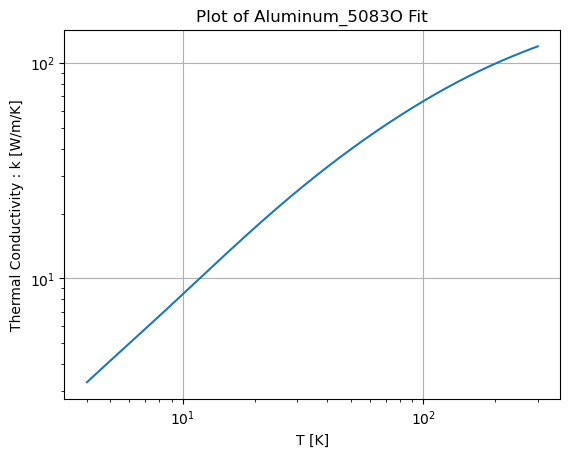

In [158]:
func_type = get_func_type(mat_parameters["fit_type"])
print(func_type)
fit_range = mat_parameters["fit_range"]
print(fit_range)
# Let's make our plotting range the listed fit range
T_range = np.linspace(fit_range[0], fit_range[1], 1000)

# Now let's use the fit to get the thermal conductivity values over the range
# Luckily, every function type is defined in such a way to readily accept the parameter dictionary as it was defined above
y_vals = func_type(T_range, mat_parameters)

# Plotting
plt.plot(T_range, y_vals)
plt.semilogy()
plt.semilogx()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.grid()
plt.show()

Great! Now that we know how to get the thermal conductivity at a given temperature value it is relatively straightforward to integrate over a specified range.

The provided function 'get_conductivity_integral' uses the built-in numpy.trapz function to calculate the integral.

In [159]:
T_low, T_high = [4, 300]
tc_integral = get_conductivity_integral(T_low, T_high, material_of_interest)

print(f"{tc_integral} W/m")

23150.49344547068 W/m


Just for fun, let's see what that region looks like on the plot

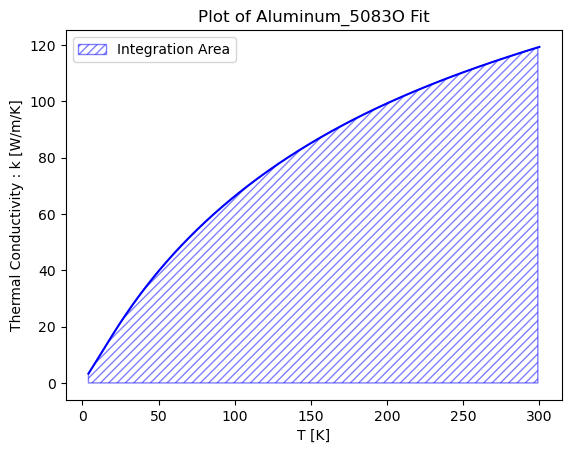

In [160]:
# Plotting
fill_between_range = np.arange(T_low, T_high)
plt.plot(T_range, y_vals, color="b")
plt.fill_between(fill_between_range, np.zeros(len(fill_between_range)), func_type(fill_between_range, mat_parameters),
                 hatch="////", alpha = 0.5, edgecolor = 'b', facecolor="w",
                 label="Integration Area")
# plt.semilogy()
# plt.semilogx()
plt.legend()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.show()